# Example

## Library

In [1]:
# 7DT Library
from astropy.table import Table
from astropy import constants as const
import glob, os
import sys

sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

# plt.style.use('dark_background') # Dark Mode Style

Use `med25nm`, `med50nm`, `broad` as `group_name`


## 7DT Modules

In [2]:
#	Subsequent filter info [AA]
bandmin=4000
bandmax=9000
bandwidth=250
bandstep=125
#	Maximum transmission of each filters
bandrsp=0.95
#	Wavelength bin [AA]
lammin=1000
lammax=10000
lamres=1000
#	Seeing Condition
seeing = 1.5

- Calculate Exposure Times

In [3]:
n_yr = 5.
eff_factor = 0.7
# exptime_single = 60.
# exptime_single = 180.
exptime_single = 600.

- RIS

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


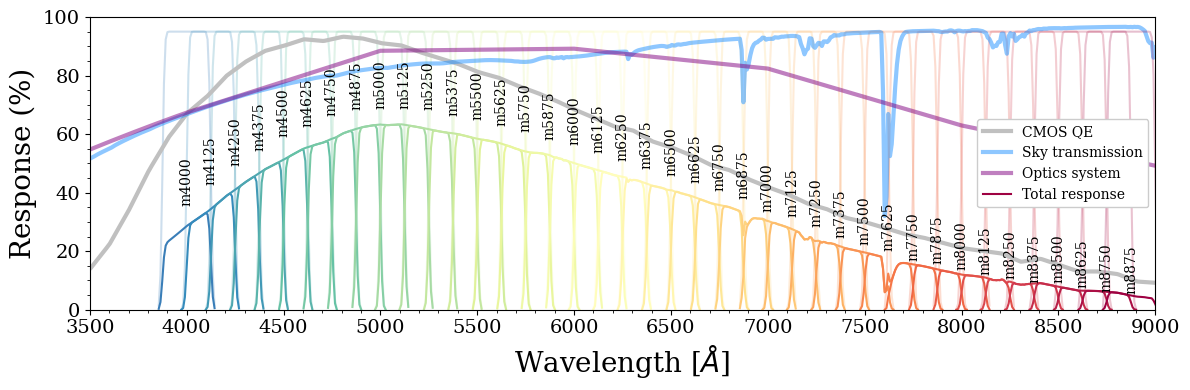

In [4]:
#	Exposure Time [s]
sdt = SevenDT()
sdt.echo_optics()
filterset = sdt.generate_filterset(bandmin=bandmin, bandmax=bandmax, bandwidth=bandwidth, bandstep=bandstep, bandrsp=bandrsp, lammin=lammin, lammax=lammax, lamres=lamres)
T_qe = sdt.get_CMOS_IMX455_QE()
sdt.get_optics()
s = sdt.get_sky()
sdt.smooth_sky()
totrsptbl = sdt.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt.get_phot_aperture(exptime=exptime_single, fwhm_seeing=seeing, optfactor=1.0, verbose=False)
outbl_ris = sdt.get_depth_table(Nsigma=5)
sdt.get_speclite()

## Synthetic Photometry

### Feige 110 (Standard Star)

In [5]:
sptbl = Table.read('../data/Example_Spectra/fFeige110.dat', format='ascii')
sptbl[:5]

col1,col2
float64,float64
3000.05,5.89165e-13
3000.15,5.89077e-13
3000.25,5.89013e-13
3000.35,5.88959e-13
3000.45,5.88903e-13


In [6]:
lam = sptbl['col1']*u.Angstrom
flam = sptbl['col2']*flamunit

filter,lam,bandwidth,magabs,snr,magapp,magobs,magerr,fnuobs,fnuerr,fnu
,Angstrom,,,,mag(AB),mag(AB),mag(AB),uJy,uJy,uJy
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
m4000,4010.792,250.000,11.252,1544.637,11.252,11.252,0.010,114585.726,74.183,114615.839
m4125,4134.015,250.000,11.279,1663.538,11.279,11.278,0.010,111883.776,67.257,111838.132
m4250,4257.559,250.000,11.335,1735.147,11.335,11.335,0.010,106124.399,61.162,106136.751
m4375,4380.872,250.000,11.389,1779.836,11.389,11.390,0.010,100958.665,56.724,100997.574
m4500,4504.837,250.000,11.426,1812.484,11.426,11.425,0.010,97725.972,53.918,97612.463


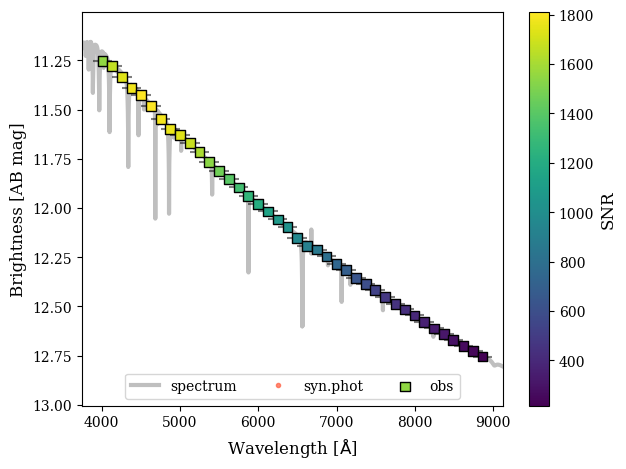

In [7]:
mobstbl = sdt.get_synphot2obs(flam, lam, z=None, z0=None, figure=True)
mobstbl[:5]

### High-z QSO Model

In [8]:
sptbl = Table.read('../data/Example_Spectra/Highz_QSO_model.dat', format='ascii')
sptbl[:3]

col0_1,col0_2
float64,float64
3701.0,0.00869814966945632
3702.0,0.008708863212672578
3703.0,0.00871958452327259


In [9]:
sptbl.rename_columns(['col0_1', 'col0_2'], ['lam', 'fnu'])
sptbl['lam'].unit = u.Angstrom
sptbl['fnu'].unit = u.uJy

In [10]:
lam = sptbl['lam']
fnu = sptbl['fnu'] #.to(u.erg / (u.second * u.cm**2 * u.Hz))

In [11]:
flam = convert_fnu2flam(fnu, lam)
sptbl['flam'] = flam

filter,lam,bandwidth,magabs,snr,magapp,magobs,magerr,fnuobs,fnuerr,fnu
,Angstrom,,,,mag(AB),mag(AB),mag(AB),uJy,uJy,uJy
str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
m4000,4010.792,250.000,28.562,0.014,28.562,31.668,4.629,0.001,0.055,0.014
m4125,4134.015,250.000,28.253,0.023,28.253,21.878,4.142,6.437,285.655,0.018
m4250,4257.559,250.000,27.920,0.035,27.920,32.862,3.674,0.000,0.007,0.025
m4375,4380.872,250.000,27.503,0.057,27.503,25.473,3.171,0.235,4.123,0.036
m4500,4504.837,250.000,26.914,0.105,26.914,25.772,2.556,0.178,1.699,0.062


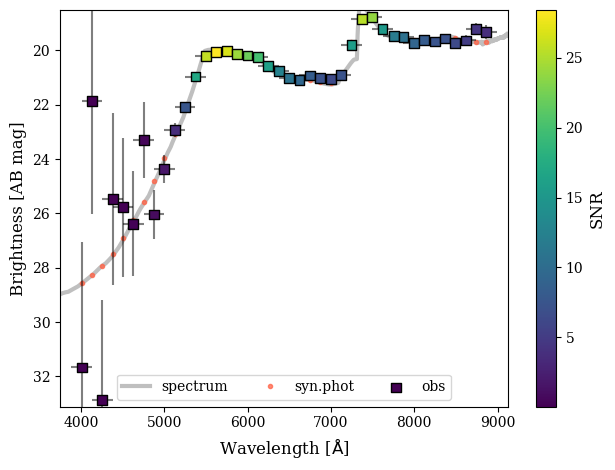

In [12]:
mobstbl = sdt.get_synphot2obs(flam, lam, z=None, z0=None, figure=True)
mobstbl[:5]

- Different format (magnitude)

In [19]:
filterarr = mobstbl['filter'].value
filterarr

array(['m4000', 'm4125', 'm4250', 'm4375', 'm4500', 'm4625', 'm4750',
       'm4875', 'm5000', 'm5125', 'm5250', 'm5375', 'm5500', 'm5625',
       'm5750', 'm5875', 'm6000', 'm6125', 'm6250', 'm6375', 'm6500',
       'm6625', 'm6750', 'm6875', 'm7000', 'm7125', 'm7250', 'm7375',
       'm7500', 'm7625', 'm7750', 'm7875', 'm8000', 'm8125', 'm8250',
       'm8375', 'm8500', 'm8625', 'm8750', 'm8875'], dtype='<U5')

In [23]:
outbl = Table()
for ff, filte in enumerate(filterarr):
	#	Source Magnitude
	magappkey = f"magapp_{filte}"
	magapp = mobstbl['magapp'][ff].item()
	#	Magnitude with a scatter
	magobskey = f"magobs_{filte}"
	magobs = mobstbl['magobs'][ff].item()
	#	Magnitude Error
	magerrkey = f"magerr_{filte}"
	magerr = mobstbl['magerr'][ff].item()
	#	SNR
	snrkey = f"snr_{filte}"
	snr = mobstbl['snr'][ff].item()

	keys = [magappkey, magobskey, magerrkey, snrkey]
	values = [magapp, magobs, magerr, snr]

	for key, value in zip(keys, values):
		outbl[key] = [value]
		outbl[key].format = '.6f'

In [24]:
outbl

magapp_m4000,magobs_m4000,magerr_m4000,snr_m4000,magapp_m4125,magobs_m4125,magerr_m4125,snr_m4125,magapp_m4250,magobs_m4250,magerr_m4250,snr_m4250,magapp_m4375,magobs_m4375,magerr_m4375,snr_m4375,magapp_m4500,magobs_m4500,magerr_m4500,snr_m4500,magapp_m4625,magobs_m4625,magerr_m4625,snr_m4625,magapp_m4750,magobs_m4750,magerr_m4750,snr_m4750,magapp_m4875,magobs_m4875,magerr_m4875,snr_m4875,magapp_m5000,magobs_m5000,magerr_m5000,snr_m5000,magapp_m5125,magobs_m5125,magerr_m5125,snr_m5125,magapp_m5250,magobs_m5250,magerr_m5250,snr_m5250,magapp_m5375,magobs_m5375,magerr_m5375,snr_m5375,magapp_m5500,magobs_m5500,magerr_m5500,snr_m5500,magapp_m5625,magobs_m5625,magerr_m5625,snr_m5625,magapp_m5750,magobs_m5750,magerr_m5750,snr_m5750,magapp_m5875,magobs_m5875,magerr_m5875,snr_m5875,magapp_m6000,magobs_m6000,magerr_m6000,snr_m6000,magapp_m6125,magobs_m6125,magerr_m6125,snr_m6125,magapp_m6250,magobs_m6250,magerr_m6250,snr_m6250,magapp_m6375,magobs_m6375,magerr_m6375,snr_m6375,magapp_m6500,magobs_m6500,magerr_m6500,snr_m6500,magapp_m6625,magobs_m6625,magerr_m6625,snr_m6625,magapp_m6750,magobs_m6750,magerr_m6750,snr_m6750,magapp_m6875,magobs_m6875,magerr_m6875,snr_m6875,magapp_m7000,magobs_m7000,magerr_m7000,snr_m7000,magapp_m7125,magobs_m7125,magerr_m7125,snr_m7125,magapp_m7250,magobs_m7250,magerr_m7250,snr_m7250,magapp_m7375,magobs_m7375,magerr_m7375,snr_m7375,magapp_m7500,magobs_m7500,magerr_m7500,snr_m7500,magapp_m7625,magobs_m7625,magerr_m7625,snr_m7625,magapp_m7750,magobs_m7750,magerr_m7750,snr_m7750,magapp_m7875,magobs_m7875,magerr_m7875,snr_m7875,magapp_m8000,magobs_m8000,magerr_m8000,snr_m8000,magapp_m8125,magobs_m8125,magerr_m8125,snr_m8125,magapp_m8250,magobs_m8250,magerr_m8250,snr_m8250,magapp_m8375,magobs_m8375,magerr_m8375,snr_m8375,magapp_m8500,magobs_m8500,magerr_m8500,snr_m8500,magapp_m8625,magobs_m8625,magerr_m8625,snr_m8625,magapp_m8750,magobs_m8750,magerr_m8750,snr_m8750,magapp_m8875,magobs_m8875,magerr_m8875,snr_m8875
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
28.561575,31.667768,4.629212,0.014272,28.253141,21.878361,4.142170,0.022533,27.920077,32.862113,3.674390,0.035094,27.502998,25.473253,3.171492,0.056946,26.914250,25.771810,2.555812,0.104962,26.244801,26.378070,1.931467,0.203109,25.582117,23.303358,1.391220,0.384406,24.808106,26.040259,0.885224,0.793787,23.958131,24.371402,0.503474,1.695413,23.086282,22.931928,0.271457,3.523181,22.086399,22.087465,0.133698,7.653854,20.924424,20.965203,0.062869,16.997422,20.204497,20.224097,0.042457,25.816300,19.978355,20.054135,0.038843,28.430158,20.021590,20.020871,0.041180,26.681917,20.126353,20.130455,0.045227,24.118965,20.201064,20.190850,0.049207,22.038771,20.287066,20.238294,0.054175,19.895745,20.538451,20.570124,0.066334,16.061916,20.818899,20.775436,0.083861,1